In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib notebook

In [3]:
FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)
fullStockListDf

,0
0,AAL
1,ABF
2,ADM
3,AHT
4,ANTO
...,...
110,UU.
111,VOD
112,WG.
113,WPP


# Tilt Function 
Input : DataFrame with companies as index names and tilt weights (-2% > tilt > 2%) in 'Weights' column

see below function for example

In [190]:
def tiltFTSE(tilt):
    #iterates over quarter in period
    tilt = tilt.divide(100)
    
    for idx, quarter in enumerate(quarterNames):
        print(quarter)
        #gets index (trading days) for each quarter
        index = FTSE[(FTSE['Date'] >= quarterCutOffDates[idx]) & (FTSE['Date'] < quarterCutOffDates[idx+1])].Date.values

        #imports data for that quarter
        stockWeightsOpen = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Open.csv'.format(quarter))
        stockWeightsOpen.drop(columns = 'Unnamed: 0', inplace = True)
        #print(stockWeightsOpen)
        stockWeightsClose = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Close.csv'.format(quarter))
        stockWeightsClose.drop(columns = 'Unnamed: 0', inplace = True)

        totalMCsOpen = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Open.csv'.format(quarter))
        totalMCsOpen.drop(columns = 'Unnamed: 0', inplace = True)
        
        totalMCsClose = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Close.csv'.format(quarter))
        totalMCsClose.drop(columns = 'Unnamed: 0', inplace = True)

        stockMarketCapsEachQuarterOpen = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Open.csv'.format(quarter))
        stockMarketCapsEachQuarterOpen.drop(columns = 'Unnamed: 0', inplace = True)
        #print(stockMarketCapsEachQuarterOpen)
        stockMarketCapsEachQuarterClose = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Close.csv'.format(quarter))
        stockMarketCapsEachQuarterClose.drop(columns = 'Unnamed: 0', inplace = True)

        #iterates over each stock in the FTSE that quarter
        #stockidx = 0
        totalMCsCloseLast = totalMCsClose['0'].iloc[-1]
        sumWeights = totalMCsOpen
        
        stockidx = 0
        for stock in FTSEStocksEachQuarter[quarter]:
            #sumWeights = pd.series([(-weight) if tilt.loc[stock][0]+weight<0 else tilt.loc[stock][0] for weight in stockWeightsOpen[stock]])
            
            weightClose = stockWeightsClose[stock].iloc[-1]
            #print('weight close',)
            if stockidx == 0:
                sumWeights = pd.Series([(-weight) if tilt.loc[stock][0]+weight<0 else tilt.loc[stock][0] + weight for weight in stockWeightsOpen[stock]])
                #print(sumWeights)
                if tilt.loc[stock][0] + weightClose < 0:
                    sumWeightsLastClose = -weightClose
                else:
                    sumWeightsLastClose = tilt.loc[stock][0] + weightClose
            else:
                sumWeights += pd.Series([(-weight) if tilt.loc[stock][0]+weight<0 else tilt.loc[stock][0] + weight for weight in stockWeightsOpen[stock]])
                
                if tilt.loc[stock][0] + weightClose < 0:
                    sumWeightsLastClose -= weightClose
                else:
                    sumWeightsLastClose += tilt.loc[stock][0] + weightClose
            #print(sumWeights)
            stockidx += 1
            #marketCapChangeOpen = pd.Series([-weight*totalMCsOpen['0'].iloc[indx] if tilt.loc[stock][0]+weight<0 else tilt.loc[stock][0]*stockMarketCapsEachQuarterOpen[stock].iloc[indx] for indx,weight in enumerate(stockWeightsOpen[stock])])
            #print(stockMarketCapsEachQuarterClose[stock].iloc[-1])
            '''
            weightClose = stockWeightsClose[stock].iloc[-1]
            
            if tilt.loc[stock][0] + weightClose < 0:
                marketCapChangeClose = -weightClose*stockMarketCapsEachQuarterClose[stock].iloc[-1]
            else:
                marketCapChangeClose = tilt.loc[stock][0]*stockMarketCapsEachQuarterClose[stock].iloc[-1]
                
            #marketCapChangeClose = [ if tilt.loc[stock][0]+weight<0 else tilt.loc[stock][0]*stockMarketCapsEachQuarterClose[stock].iloc[-1] for indx,weight in enumerate(stockWeightsClose[stock].iloc[-1])]
            '''
            #marketCapChangeOpen.multiply()
            #print('before',totalMCsOpen,marketCapChangeOpen)
        
           
            #totalMCsCloseLast +=  marketCapChangeClose          
            #print('after',totalMCsOpen)
            #print(stock,marketCapChangeOpen)
            
            #totalMCsOpen
            
            
            
            #adds tilt from aray to the company weight
            #print('before',stockWeightsOpen[stock],tilt.loc[stock][0])
            #stockWeightsOpen[stock] = stockWeightsOpen[stock].add(tilt.loc[stock][0])
            #stockWeightsClose[stock] = stockWeightsClose[stock].add(tilt.loc[stock][0])
            #print('after',stockWeightsOpen[stock])
        #print(totalMCsOpen['0'], sumWeights)
        newTotalMarketCapsOpen = totalMCsOpen['0']* sumWeights
        #print(newTotalMarketCapsOpen)
        #print('close',sumWeightsLastClose,totalMCsClose['0'].iloc[-1])
        closeTotalMC = sumWeightsLastClose*totalMCsClose['0'].iloc[-1]
        #print(closeTotalMC)
        #if weight is <0 then set to 0
        #stockWeightsOpen[stockWeightsOpen < 0] = 0
        #stockWeightsClose[stockWeightsClose < 0] = 0
        #print(stockMarketCapsEachQuarterOpen.values)
        #calculates effective market caps using new weight and old market caps 
        #newMarketCapsOpen = stockWeightsOpen*stockMarketCapsEachQuarterOpen.values
        #newMarketCapsClose = stockWeightsClose*stockMarketCapsEachQuarterClose.values

        #calculates new total market cap each day
        #newTotalMarketCapsOpen = newMarketCapsOpen.sum(axis=1).to_frame()
        #newTotalMarketCapsClose = newMarketCapsClose.sum(axis=1).to_frame()

        #newTotalMarketCapsOpen = totalMCsOpen
        #newTotalMarketCapsClose = totalMCsClose
        
        #calculates index divisor to make sure price stays continuous over the change in quarter
        #print(newTotalMarketCapsOpen)
        #print(newTotalMarketCapsOpen.iloc[0])
        if idx == 0:
            #for the first quarter the reference price is the real FTSE price from that day - abitrary starting point
            indexDivisorForQuarter = newTotalMarketCapsOpen.iloc[0]/(FTSE[FTSE['Date'] == quarterCutOffDates[idx]]['Open'].values[0])
        else:
            indexDivisorForQuarter = newTotalMarketCapsOpen.iloc[0]/quarterClose
        print(indexDivisorForQuarter,closeTotalMC)

        quarterClose = closeTotalMC / indexDivisorForQuarter
        #calculates new tilted price using index divisor and tilted market caps
        newTotalMarketCapsOpen = newTotalMarketCapsOpen.to_frame()
        FTSEPriceQuarterly = newTotalMarketCapsOpen.divide(indexDivisorForQuarter).set_index(index, drop=True)
        FTSEPriceQuarterly.rename(columns={0:"Open"}, inplace=True)
        #FTSEPriceQuarterly['Close'] = newTotalMarketCapsClose.divide(indexDivisorForQuarter).set_index(index, drop=True)


        if idx == 0:
            FTSEPrice3yr = FTSEPriceQuarterly

        else:
            FTSEPrice3yr = FTSEPrice3yr.append(FTSEPriceQuarterly)

    FTSEPrice3yr.rename(columns={'0':"Open"}, inplace=True)
    
    return FTSEPrice3yr
   

In [35]:
stockWeightsOpen

NameError: name 'stockWeightsOpen' is not defined

Example Input

In [192]:
tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)
tiltWeights['Weights'] = np.random.uniform(-2,2,tiltWeights.shape[0])
#tiltWeights['Weights'] = np.zeros(tiltWeights.shape[0])
#tiltWeights['Weights'] = np.full((tiltWeights.shape[0],1),2)
tiltWeights

,Weights
AAL,-0.917636
ABF,1.750266
ADM,0.599468
AHT,-0.028771
ANTO,1.881224
...,...
UU.,0.188730
VOD,1.472743
WG.,-0.419641
WPP,0.417372


In [193]:
tiltedFTSE = tiltFTSE(tiltWeights)
print(tiltedFTSE)


Q3,17
378213001.6373648 2717080210242.848
Q4,17
374803111.4313907 2817260191718.8145
Q1,18
376781839.0924064 2682831122331.919
Q2,18
374623025.0267684 2852614347879.0967
Q3,18
382832934.3697085 2863631810966.9424
Q4,18
381856599.984244 2576660214331.121
Q1,19
417288879.98149896 3048291793955.463
Q2,19
416925944.60454726 3154011397179.034
Q3,19
385735334.0089975 2842944650122.1343
Q4,19
386469910.57701117 2895044958807.9404
                   Open
2017-06-19  7463.500000
2017-06-20  7481.490496
2017-06-21  7407.080582
2017-06-22  7364.073747
2017-06-23  7342.216094
...                 ...
2019-12-16  7266.759127
2019-12-17  7389.745132
2019-12-18  7416.641076
2019-12-19  7458.356051
2019-12-20  7489.612746

[638 rows x 1 columns]


<IPython.core.display.Javascript object>


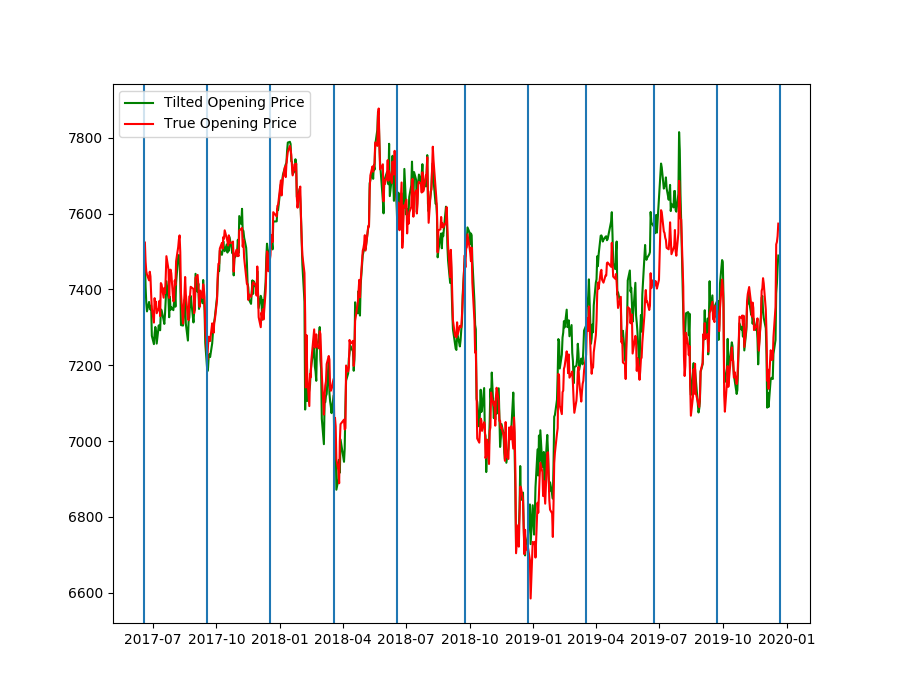

In [194]:
FTSEq317 = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Open'].values
FTSEq317date = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Date'].values

f = plt.figure(figsize=(9,7))
axs = f.add_subplot(111)
axs.plot(tiltedFTSE.index.values,tiltedFTSE['Open'].values,'g', label = 'Tilted Opening Price')
axs.plot(FTSEq317date,FTSEq317,'r', label = 'True Opening Price')
axs.legend()
for quarter in quarterCutOffDates:
    axs.axvline(x=quarter)